<a href="https://colab.research.google.com/github/Mukti-J/Exercise/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install openpyxl
!pip install scikit-plot matplotlib
!pip install imblearn

In [ ]:
# Import Python Package
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, Bidirectional, LSTM

In [ ]:
# Load and clean data
data = pd.read_excel("/content/Telco_customer_churn.xlsx")
data = data.dropna(subset=['Churn Value'])  # Drop if churn missing

# Set target and features
y = data['Churn Value']
X = data.drop(['CustomerID', 'Churn Label', 'Churn Value'], axis=1)

# Encode categorical columns
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle imbalance
X_bal, y_bal = SMOTE().fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
#Building Models

# MLP Model
def build_mlp(input_dim):
    inp = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inp)
    x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

# CNN Model
def build_cnn(input_dim):
    inp = Input(shape=(input_dim, 1))
    x = Conv1D(32, 3, activation='relu')(inp)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

# BiLSTM Model
def build_bilstm(input_dim):
    inp = Input(shape=(input_dim, 1))
    x = Bidirectional(LSTM(32))(inp)
    x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

# Build and train
mlp = build_mlp(X_train.shape[1])
cnn = build_cnn(X_train.shape[1])
bilstm = build_bilstm(X_train.shape[1])

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

mlp.fit(X_train, y_train, epochs=10, verbose=0)
cnn.fit(X_train_reshaped, y_train, epochs=10, verbose=0)
bilstm.fit(X_train_reshaped, y_train, epochs=10, verbose=0)

# Generate

In [ ]:
train_preds = np.column_stack([
    mlp.predict(X_train).flatten(),
    cnn.predict(X_train_reshaped).flatten(),
    bilstm.predict(X_train_reshaped).flatten()
])

test_preds = np.column_stack([
    mlp.predict(X_test).flatten(),
    cnn.predict(X_test_reshaped).flatten(),
    bilstm.predict(X_test_reshaped).flatten()
])

259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# Train meta-model
meta_model = LogisticRegression()
meta_model.fit(train_preds, y_train)
meta_probs = meta_model.predict_proba(test_preds)[:, 1]



65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


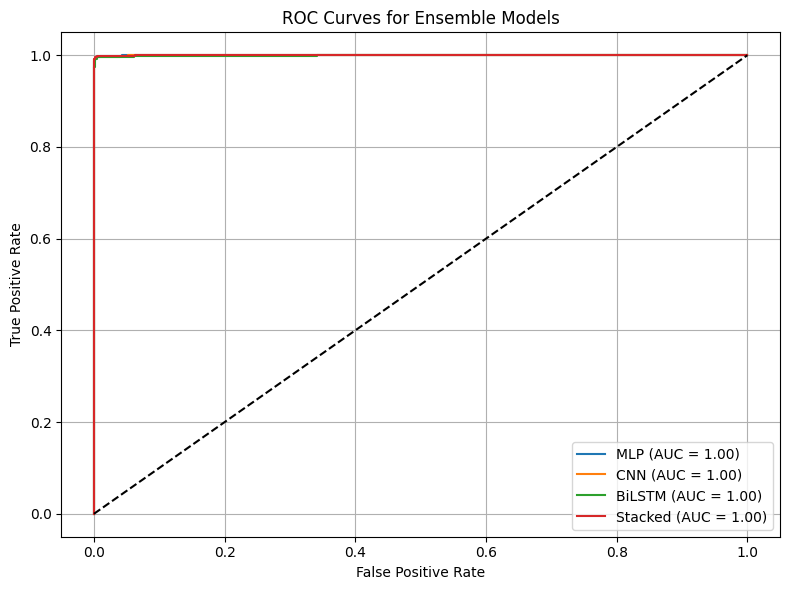

In [ ]:
# Plot ROC curves
def plot_roc(y_true, probs_dict):
    plt.figure(figsize=(8, 6))
    for name, probs in probs_dict.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Ensemble Models")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc(y_test, {
    "MLP": mlp.predict(X_test).flatten(),
    "CNN": cnn.predict(X_test_reshaped).flatten(),
    "BiLSTM": bilstm.predict(X_test_reshaped).flatten(),
    "Stacked": meta_probs
})

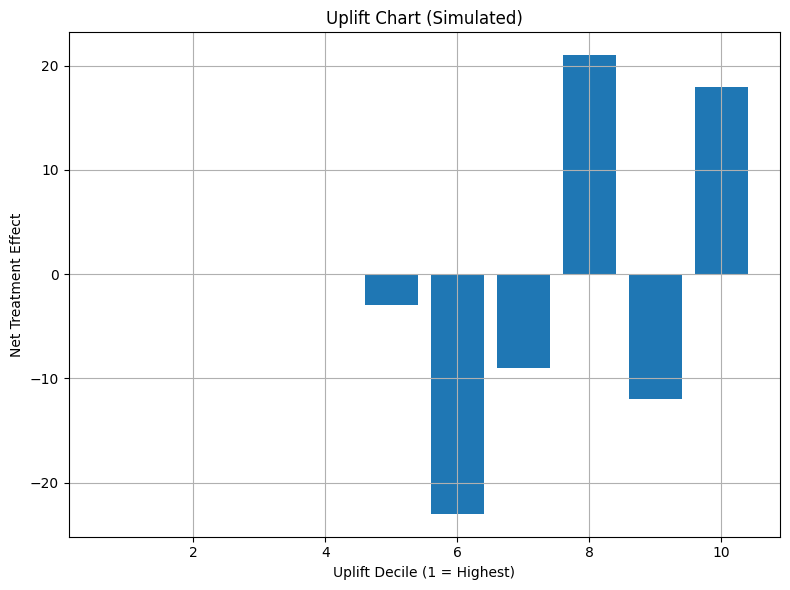

In [ ]:
# ---------- Uplift Chart (Simulated Treatment) ----------
np.random.seed(42)
treatment = np.random.binomial(1, 0.5, len(meta_probs))
response = (meta_probs + 0.2 * treatment > 0.5).astype(int)  # Simulated outcome
uplift_score = meta_probs  # Use model probability as proxy for uplift

uplift_df = pd.DataFrame({
    'uplift': uplift_score,
    'treatment': treatment,
    'outcome': response
})
uplift_df['decile'] = pd.qcut(uplift_df['uplift'], 10, labels=False)

uplift_chart = []
for i in range(10):
    group = uplift_df[uplift_df['decile'] == i]
    treat_resp = group[(group['treatment'] == 1) & (group['outcome'] == 1)].shape[0]
    control_resp = group[(group['treatment'] == 0) & (group['outcome'] == 1)].shape[0]
    uplift = treat_resp - control_resp
    uplift_chart.append(uplift)

plt.figure(figsize=(8, 6))
plt.bar(range(1, 11), uplift_chart)
plt.xlabel("Uplift Decile (1 = Highest)")
plt.ylabel("Net Treatment Effect")
plt.title("Uplift Chart (Simulated)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Predict final outputs from stacked meta-learner
final_preds = meta_model.predict(test_preds)
final_probs = meta_model.predict_proba(test_preds)[:, 1]

# Evaluate
print("Stacked Model Evaluation:")
print("Accuracy:", round(accuracy_score(y_test, final_preds), 4))
print("F1 Score:", round(f1_score(y_test, final_preds), 4))
print("ROC AUC:", round(roc_auc_score(y_test, final_probs), 4))

Stacked Model Evaluation:
Accuracy: 0.9961
F1 Score: 0.9962
ROC AUC: 0.9999



Confusion Matrix:
[[1013    2]
 [   6 1049]]


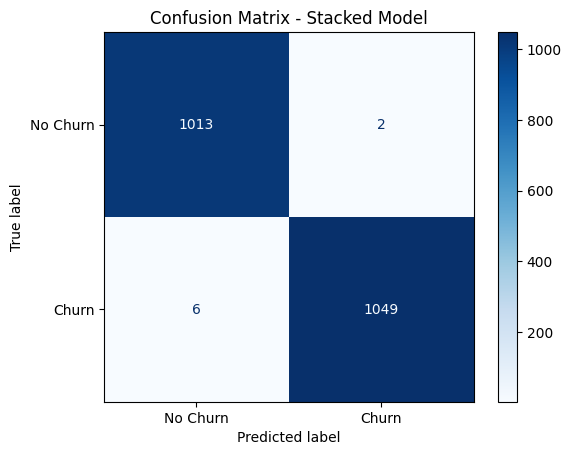

In [ ]:
# Compute and print confusion matrix
cm = confusion_matrix(y_test, final_preds)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Stacked Model")
plt.grid(False)
plt.show()